# LLMs e IA Generativa

## Agentes para chatbot de CVs

### Arquitectura ReAct

In [ ]:
from RAG import RAG

from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from pathlib import Path
import os

from langchain.tools import Tool

from dotenv import load_dotenv

load_dotenv()

In [2]:
# Inicializar la clase RAG
groq_model="llama3-8b-8192"
embedding_model_name="all-MiniLM-L6-v2"
embedding_model_dim=384
index_name = "cvs-embeddings"
rag = RAG(embedding_model_name, embedding_model_dim, index_name, groq_model)
path = Path('docs/')
rag.load_documents(path)

# Registrar como herramienta
rag_tool_langchain = Tool(
    name="RAG_Tool",
    func=rag,
    description="Una herramienta para responder preguntas utilizando recuperación de contexto y un modelo LLM en Groq."
)

# Inicializar un LLM base
ChatGroq.api_key = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model_name="llama3-8b-8192")

# Inicializar el agente con la herramienta RAG
tools = [rag_tool_langchain]

In [3]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [4]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_groq)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_groq(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            # Mapero de la respuesta del tool
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [5]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

abot = Agent(llm, tools, system=prompt)

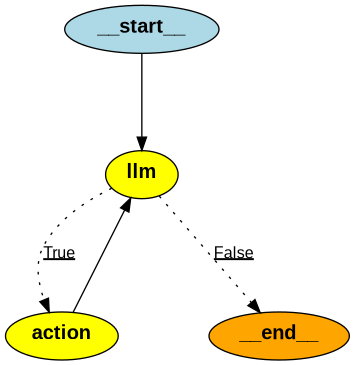

In [6]:
import pygraphviz
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [7]:
messages = [HumanMessage(content="Does Javier know Java language?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'RAG_Tool', 'args': {'__arg1': 'Javier'}, 'id': 'call_cf7z', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'RAG_Tool', 'args': {'__arg1': 'Java'}, 'id': 'call_bp3h', 'type': 'tool_call'}
Back to the model!


In [8]:
import pprint
pprint.pprint(result)

{'messages': [HumanMessage(content='Does Javier know Java language?', additional_kwargs={}, response_metadata={}),
              AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_cf7z', 'function': {'arguments': '{"__arg1":"Javier"}', 'name': 'RAG_Tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 1000, 'total_tokens': 1069, 'completion_time': 0.0575, 'prompt_time': 0.04504214, 'queue_time': 0.0016693230000000003, 'total_time': 0.10254214}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0ae297b3-2497-4bf1-b0e0-0d113296e0a6-0', tool_calls=[{'name': 'RAG_Tool', 'args': {'__arg1': 'Javier'}, 'id': 'call_cf7z', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1000, 'output_tokens': 69, 'total_tokens': 1069}),
              ToolMessage(content='Based on the provided information, here is an answer to the question "Javier":\n\nJavi